# Setup

## Imports

In [1]:
!pip install transformers
!pip install datasets
!pip install sacrebleu
!pip install -U nltk
!pip install rouge_score

     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 37.5 MB/s 
     |████████████████████████████████| 61 kB 565 kB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 4.6 MB/s 
     |████████████████████████████████| 243 kB 31.4 MB/s 
     |████████████████████████████████| 132 kB 30.7 MB/s 
     |████████████████████████████████| 1.1 MB 32.0 MB/s 
     |████████████████████████████████| 160 kB 35.9 MB/s 
     |████████████████████████████████| 271 kB 33.5 MB/s 
     |████████████████████████████████| 192 kB 40.8 MB/s 
     |████████████████████████████████| 90 kB 3.4 MB/s 
     |████████████████████████████████| 1.5 MB 4.2 MB/s 
     |████████████████████████████████| 749 kB

In [1]:
import h5py, os, json, pathlib, io, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from PIL import Image
from matplotlib import rcParams
from datasets import load_metric
from torch.utils.data import Dataset
from collections.abc import Callable
from transformers.models.beit.modeling_beit import *
from transformers import (BertModel, BertTokenizerFast, GPT2Model, GPT2TokenizerFast, ViTModel, ViTFeatureExtractor, BeitFeatureExtractor,
                          VisionEncoderDecoderConfig, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments)

## Data & model paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# MAIN PATHS
drive_path = 'drive/MyDrive/Tesi/'
data_path = drive_path + 'dataset/'
checkpoints_path = drive_path + 'checkpoints/'
module_path = drive_path.replace('/', '.') + 'modules.'

# modules saved on drive
CustomTrainer = importlib.import_module(module_path + 'custom_trainer').CustomTrainer
CustomBeitModel = importlib.import_module(module_path + 'custom_beit_model').CustomBeitModel

In [3]:
# class to hold components of Encoder-Decoder model
class modelComponents():
  def __init__(self, encoder, encoder_checkpoint, decoder, decoder_checkpoint, img_processor, tokenizer):
    self.encoder_checkpoint = encoder_checkpoint
    self.decoder_checkpoint = decoder_checkpoint
    self.img_processor = img_processor
    self.tokenizer = tokenizer
    self.encoder = encoder
    self.decoder = decoder

In [4]:
# component configurations
vit_bert = modelComponents(encoder=ViTModel, encoder_checkpoint='google/vit-base-patch16-224-in21k',
                           decoder=BertModel, decoder_checkpoint='bert-base-uncased',
                           img_processor=ViTFeatureExtractor, tokenizer=BertTokenizerFast)

vit_gpt2 = modelComponents(encoder=ViTModel, encoder_checkpoint='google/vit-base-patch16-224-in21k',
                           decoder=GPT2Model, decoder_checkpoint='gpt2',
                           img_processor=ViTFeatureExtractor, tokenizer=GPT2TokenizerFast)

beit_gpt2 = modelComponents(encoder=CustomBeitModel, encoder_checkpoint='microsoft/beit-base-patch16-224-pt22k',
                           decoder=GPT2Model, decoder_checkpoint='gpt2',
                           img_processor=BeitFeatureExtractor, tokenizer=GPT2TokenizerFast)

In [5]:
# DATA PATHS
word_map_file = drive_path + 'WORDMAP.json'
cap_train_file = data_path + 'TRAIN_CAPTIONS.json'
cap_val_file = data_path + 'VAL_CAPTIONS.json'

path_to_train_imgs = os.path.join(data_path, 'TRAIN_IMAGES.hdf5')
path_to_val_imgs = os.path.join(data_path, 'VAL_IMAGES.hdf5')

## Device & Batch size

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16

# Model and Data setup

## Captions

In [7]:
def load_captions(split):
  assert split in ['train', 'val']
  file = cap_train_file if split=='train' else cap_val_file
  # load captions from file
  with open(file, 'r') as j:
    captions = pd.Series(json.load(j))
  # load wordmap from file
  with open(word_map_file, 'r') as f:
    word_map = json.load(f)
  #return decoded captions
  id_2_word = {x: y for y, x in word_map.items()}
  return captions.apply(lambda caption: ' '.join([id_2_word[w] for w in caption if w not in {word_map['<start>'], word_map['<pad>'], word_map['<end>'], word_map['<unk>']}]))

def tokenize_captions(cap_train, cap_val, tokenizer):
  # append all captions in a single list
  n_train = len(cap_train)
  cap = cap_train.append(cap_val, ignore_index=True)
  # tokenize all captions in a single batch
  # this way we can easily set the padding lenght to match the longest sentence in the dataset
  with tokenizer.as_target_tokenizer():
      cap = tokenizer(cap.to_list(), return_tensors="pt", padding='longest', truncation=True).input_ids
  assert len(cap_train)+len(cap_val) == len(cap)
  # split into train and validation again
  cap_train = cap[0:n_train]
  cap_val = cap[n_train:]
  return cap_train, cap_val

def load_and_tokenize_captions(tokenizer):
  cap_train = load_captions('train')
  cap_val = load_captions('val')
  return tokenize_captions(cap_train, cap_val, tokenizer)

## Images

In [8]:
def load_images():
  # we load a reference to the h5 data, not the data itself
  img_train = h5py.File(path_to_train_imgs, mode="r")['images']
  img_val = h5py.File(path_to_val_imgs, mode="r")['images']
  return img_train, img_val

## Dataset class

In [9]:
class CustomDataset(Dataset):
    def __init__(self, captions, images, img_processor, n_samples):
        self.captions = captions
        self.images = images
        self.img_processor = img_processor
        self.n_samples = n_samples
        if(self.n_samples == -1): self.n_samples = len(self.images)
        else: assert n_samples <= len(self.images), 'n_samples must be <=' + str(len(self.images))

    def __getitem__(self, index):
        return {'pixel_values':self.preprocess_image(self.images[index]),
                'labels': self.captions[index]}

    def __len__(self):
        return self.n_samples

    def channel_first_to_last(self, img):
      return img.swapaxes(0, 1).swapaxes(1, 2)

    def preprocess_image(self, image):
      image = np.array(self.channel_first_to_last(image))
      return self.img_processor(image, return_tensors="pt")['pixel_values'][0]

## Model and Dataset init

In [10]:
def load_data(tokenizer, img_processor, n_train, n_val):
  img_train, img_val = load_images()
  cap_train, cap_val = load_and_tokenize_captions(tokenizer)

  # TRAINING DATASET
  data_train = CustomDataset(captions=cap_train, 
                             images=img_train, 
                             img_processor=img_processor,
                             n_samples=n_train)
  # VALIDATION DATASET
  data_val = CustomDataset(captions=cap_val, 
                           images=img_val, 
                           img_processor=img_processor,
                           n_samples=n_val)
  
  return data_train, data_val

In [11]:
def init_model_and_data(component_config:modelComponents, n_train:int=-1, n_val:int=-1, checkpoint:str=None):
  # load models and their configs from pretrained checkpoints
  if(checkpoint is None):
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(component_config.encoder_checkpoint, component_config.decoder_checkpoint)
  else:
    model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

  if(component_config.encoder == CustomBeitModel):
    model.encoder = CustomBeitModel.from_pretrained(component_config.encoder_checkpoint)

  # set decoder config to causal lm
  model.config.decoder_is_decoder = True
  model.config.decoder_add_cross_attention = True

  # set img_processor & tokenizer
  img_processor = component_config.img_processor.from_pretrained(component_config.encoder_checkpoint)
  tokenizer = component_config.tokenizer.from_pretrained(component_config.decoder_checkpoint)

  # decoder-specific config
  if(component_config.decoder == BertModel):
    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.decoder_bos_token_id = tokenizer.cls_token_id
    model.config.decoder_eos_token_id = tokenizer.sep_token_id
  else:
    model.config.decoder_start_token_id = tokenizer.bos_token_id
    model.config.decoder_bos_token_id = tokenizer.bos_token_id
    model.config.decoder_eos_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token

  model.config.pad_token_id = tokenizer.pad_token_id
  model.decoder.config.pad_token_id = tokenizer.pad_token_id
  model.config.encoder.pad_token_id = tokenizer.pad_token_id

  # generation arguments
  model.config.decoder.repetition_penalty = 10.0
  model.config.decoder.no_repeat_ngram_size = 3
  model.config.decoder_start_token_id = tokenizer.bos_token_id
  model.config.decoder.eos_token_id = tokenizer.eos_token_id
  model.config.decoder.do_sample = True
  model.config.decoder.max_length = 50

  # load and prepare data
  data_train, data_val = load_data(tokenizer, img_processor, n_train, n_val)
  
  return model, tokenizer, data_train, data_val

## Train data samples

In [12]:
def show_data_sample(index):
  plt.figure(figsize=(15, 6))
  plt.imshow(img_train[index].swapaxes(0, 1).swapaxes(1, 2))
  plt.title(cap_train[index])

In [ ]:
img_train, img_val = load_images()
cap_train = load_captions('train')

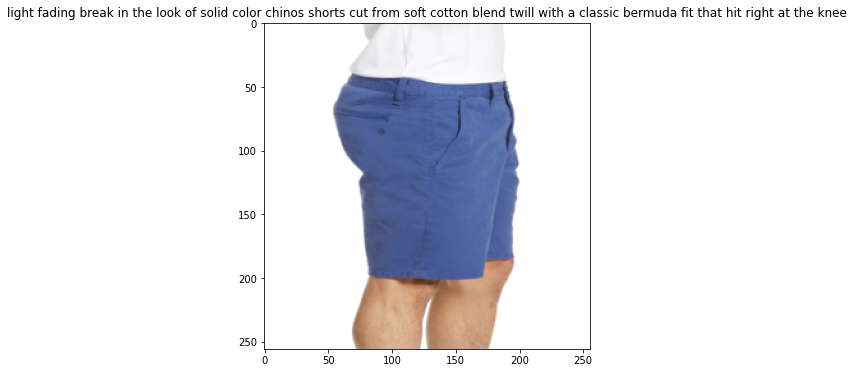

In [ ]:
show_data_sample(np.random.choice(range(0, len(img_train))))

## Decoder input size

In [12]:
def get_decoder_input_size(model, data_train):
  max_decoder_input_size = model.config.decoder.max_position_embeddings
  decoder_input_size = len(data_train[0]['labels'])
  return {'decoder_input_size':decoder_input_size, 'max_decoder_input_size':max_decoder_input_size}

# Training

## Evaluation metrics

In [13]:
# Bleu
bleu_metric = load_metric('sacrebleu')
meteor_metric = load_metric('meteor')
rouge_metric = load_metric('rouge')

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # meteor
    meteor = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # rougeL
    rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

    #split into list of tokens and remove spaces
    decoded_preds = [pred.split(' ') for pred in decoded_preds]
    decoded_labels = [[label.split(' ')] for label in decoded_labels]

    # bleu
    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    result = {"bleu": bleu["score"], "meteor": meteor['meteor']*100, "rougeL": rouge['rougeL'][1][2]*100}

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    # result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## VitBert

### Init

In [ ]:
model, tokenizer, data_train, data_val = init_model_and_data(vit_bert)

### Trainer class

In [ ]:
training_args = Seq2SeqTrainingArguments(
    dataloader_pin_memory = not device.type == 'cuda',
    per_device_train_batch_size = batch_size,   # batch size per device during training
    per_device_eval_batch_size = batch_size,    # batch size for evaluation
    output_dir = checkpoints_path,    # output directory
    overwrite_output_dir = True,
    load_best_model_at_end = False,
    predict_with_generate = True,
    generation_num_beams = 6, 
    #eval_accumulation_steps = 300,  # send logits and labels to cpu for evaluation step by step, rather thean all together
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    save_total_limit = 1,   # Only last [save_total_limit] models are saved. Older ones are deleted.
    save_steps = 500,
    eval_steps = 500,    # Evaluation and Save happens every [eval_steps] steps
    learning_rate = 3e-5,
    num_train_epochs = 5,    # total number of training epochs
    warmup_steps = 500,   # number of warmup steps for learning rate scheduler
    weight_decay = 0.03    # strength of weight decay
)

trainer = CustomTrainer(
    compute_metrics = compute_metrics,
    tokenizer = None,
    data_collator = None,
    model = model, # the instantiated 🤗 Transformers model to be trained
    args = training_args,   # training arguments, defined above
    train_dataset = data_train,   # training dataset
    eval_dataset = data_val   # evaluation dataset
)

### Training sessions

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 13276
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4980
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Gen Len
500,4.135600,2.345523,7.737500,17.323900
1000,1.711800,2.212078,7.808700,19.167200
1500,1.245900,2.273330,8.058700,19.058600
2000,0.885100,2.344582,8.603900,19.286600
2500,0.681300,2.405025,8.833500,19.637000
3000,0.551500,2.424078,8.404200,19.630600


***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/results/checkpoint-500
Configuration saved in drive/MyDrive/Tesi/results/checkpoint-500/config.json
Model weights saved in drive/MyDrive/Tesi/results/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/results/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/results/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/results/checkpoint-500] due to args.save_total_limit
/usr/l

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-2500')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from drive/MyDrive/Tesi/checkpoint-2500).
***** Running training *****
  Num examples = 13276
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4980
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 2500
  Will skip the first 1 epochs then the first 840 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/840 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Gen Len
3000,0.551500,2.423346,8.325600,19.624200
3500,0.434000,2.485209,8.772700,19.691600


***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/results/checkpoint-3000
Configuration saved in drive/MyDrive/Tesi/results/checkpoint-3000/config.json
Model weights saved in drive/MyDrive/Tesi/results/checkpoint-3000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/results/checkpoint-3500
Configuration saved in drive/MyDrive/Tesi/results/checkpoint-3500/config.json
Model weights saved in drive/MyDrive/Tesi/results/checkpoint-3500/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/results/checkpoint-3000] due to args.save_total_limit
/u

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-3500')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-3500).
***** Running training *****
  Num examples = 13276
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4980
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 3500
  Will skip the first 2 epochs then the first 180 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/180 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Gen Len
4000,0.338200,2.505887,9.011900,19.642800


***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4000/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/checkpoints/checkpoint-3500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8


Step,Training Loss,Validation Loss,Bleu,Gen Len
4000,0.338200,2.505887,9.011900,19.642800
4500,0.306200,2.526517,9.310800,19.531300


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/checkpoints/checkpoint-4000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=4980, training_loss=0.09222671018546844, metrics={'train_runtime': 4876.779, 'train_samples_per_second': 8.167, 'train_steps_per_second': 1.021, 'total_flos': 0.0, 'train_loss': 0.09222671018546844, 'epoch': 3.0})

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-4500')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-4500).
***** Running training *****
  Num examples = 13276
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8300
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 4500
  Will skip the first 2 epochs then the first 1180 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1180 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Gen Len
5000,0.295100,2.578292,9.305000,19.656600


***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5000/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/checkpoints/checkpoint-4500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8


Step,Training Loss,Validation Loss,Bleu,Gen Len
5000,0.295100,2.578292,9.305000,19.656600
5500,0.238200,2.620356,9.355700,19.664000


Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5500/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/checkpoints/checkpoint-5000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 6637
  Batch size = 8


## VitGpt2

### Init

In [14]:
checkpoint = checkpoints_path + 'VitGpt2-fashiongen-checkpoint-11000'
# model, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, n_train=60000, n_val=4000, checkpoint=checkpoint)
model, tokenizer, data_train, data_val = init_model_and_data(vit_gpt2, n_train=60000, n_val=4000, checkpoint=None)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.7.crossattention.bias', 'h.11.ln_cross_attn.weight', 'h.0.crossattention.masked_bias', 'h.1.crossattention.q_attn.weight', 'h.9.crossattention.bias', 'h.4.crossattention.bias', 'h.5.crossattention.masked_bias', 'h.5.crossattention.c_attn.weight', 'h.2.crossattention.c_proj.bias', 'h.2.ln_cross_attn.weight', 'h.6.crossattention.c_attn.weight', 'h.6.crossattention.bias', 'h.5.crossattention.c_proj.bias', 'h.8.ln_cross_attn.weight', 'h.7.ln_cross_attn.weight', 'h.11.crossattention.c_attn.weight', 'h.4.crossattention.c_proj.weight', 'h.0.crossattention.c_attn.weight', 'h.9.crossattention.q_attn.weight', 'h.1.crossattention.c_proj.weight', 'h.7.crossattention.c_attn.weight', 'h.2.crossattention.q_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.11.crossattention.bias', 'h.7.crossattention.q_attn.weight', 'h.11.crossattention.masked_bias', 'h.10.ln_cross_attn.weight', 'h.

### Trainer class

In [15]:
training_args = Seq2SeqTrainingArguments(
    dataloader_pin_memory = not device.type == 'cuda',
    per_device_train_batch_size = batch_size,   # batch size per device during training
    per_device_eval_batch_size = batch_size,    # batch size for evaluation
    output_dir = checkpoints_path,    # output directory
    overwrite_output_dir = False,
    load_best_model_at_end = False,
    predict_with_generate = True,
    generation_num_beams = 5, 
    # eval_accumulation_steps = 500,  # send logits and labels to cpu for evaluation step by step, rather thean all together
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    # save_total_limit = 1,   # Only last [save_total_limit] models are saved. Older ones are deleted.
    save_steps = 2000,
    eval_steps = 2000,    # Evaluation and Save happens every [eval_steps] steps
    learning_rate = 5e-5,
    num_train_epochs = 1,    # total number of training epochs
    warmup_steps = 500,   # number of warmup steps for learning rate scheduler
    weight_decay = 0.01    # strength of weight decay
)

trainer = CustomTrainer(
    compute_metrics = compute_metrics,
    tokenizer = None,
    data_collator = None,
    model = model, # the instantiated 🤗 Transformers model to be trained
    args = training_args,   # training arguments, defined above
    train_dataset = data_train,   # training dataset
    eval_dataset = data_val   # evaluation dataset
)

### Training sessions

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
2000,1.448000,1.778915,11.779200,13.598800,14.568500


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2158: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed

In [ ]:
# con 100000 samples invece che 60000
trainer.train()

***** Running training *****
  Num examples = 101225
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6327
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1000,1.852000,1.819632,11.139500,13.415200,13.951200


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1000/pytorch_model.bin


In [ ]:
# model from fashiongen checkpoint 11000
trainer.train()

***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
1500,1.558700,1.770639,12.529900,14.528500,14.710900


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2158: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-1500')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-1500).
***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1500
  Will skip the first 0 epochs then the first 1500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
3000,1.285000,1.749871,12.266700,14.200500,14.800100


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2158: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed

TrainOutput(global_step=3750, training_loss=0.78807705078125, metrics={'train_runtime': 8802.8284, 'train_samples_per_second': 6.816, 'train_steps_per_second': 0.426, 'total_flos': 0.0, 'train_loss': 0.78807705078125, 'epoch': 1.0})

## BeitGpt2

### Init

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained(checkpoints_path + 'BeitGpt2-checkpoint-7500')
model.encoder.save_pretrained('./temp')
model.encoder = CustomBeitModel.from_pretrained('./temp')

In [ ]:
model, tokenizer, data_train, data_val = init_model_and_data(beit_gpt2, n_train=60000, n_val=3000)

# model = VisionEncoderDecoderModel.from_pretrained(checkpoints_path + 'BeitGpt2-checkpoint-7500')
# model.encoder.save_pretrained('./temp')
# model.encoder = CustomBeitModel.from_pretrained('.temp')

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k were not used when initializing BeitModel: ['lm_head.weight', 'lm_head.bias', 'layernorm.weight', 'layernorm.bias']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitModel were not initia

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.5.crossattention.c_proj.weight', 'h.2.crossattention.c_proj.weight', 'h.7.ln_cross_attn.weight', 'h.11.crossattention.c_attn.weight', 'h.5.crossattention.masked_bias', 'h.5.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.bias', 'h.9.crossattention.masked_bias', 'h.1.crossattention.masked_bias', 'h.1.crossattention.c_proj.weight', 'h.6.crossattention.c_proj.weight', 'h.11.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.bias', 'h.8.crossattention.masked_bias', 'h.1.crossattention.c_proj.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.masked_bias', 'h.1.ln_cross_attn.weight', 'h.8.crossattention.c_attn.weight', 'h.6.ln_cross_attn.weight', 'h.8.ln_cross_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.3.crossattention.q_attn.weight', 'h.8.crossattention.q_attn.weight', 'h.9.crossattention.bias', 'h.7.crossattention.masked_bias', 'h.8.crossatten

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
len(data_train), len(data_val)

(60000, 3000)

### Trainer class

In [ ]:
training_args = Seq2SeqTrainingArguments(
    dataloader_pin_memory = not device.type == 'cuda',
    per_device_train_batch_size = batch_size,   # batch size per device during training
    per_device_eval_batch_size = batch_size,    # batch size for evaluation
    output_dir = checkpoints_path,    # output directory
    overwrite_output_dir = False,
    load_best_model_at_end = False,
    predict_with_generate = True,
    generation_num_beams = 3, 
    eval_accumulation_steps = 500,  # send logits and labels to cpu for evaluation step by step, rather thean all together
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    # save_total_limit = 1,   # Only last [save_total_limit] models are saved. Older ones are deleted.
    save_steps = 1875,
    eval_steps = 1875,    # Evaluation and Save happens every [eval_steps] steps
    learning_rate = 8e-5,
    num_train_epochs = 3,    # total number of training epochs
    warmup_steps = 500,   # number of warmup steps for learning rate scheduler
    weight_decay = 0.012    # strength of weight decay
)

trainer = CustomTrainer(
    compute_metrics = compute_metrics,
    tokenizer = None,
    data_collator = None,
    model = model, # the instantiated 🤗 Transformers model to be trained
    args = training_args,   # training arguments, defined above
    train_dataset = data_train,   # training dataset
    eval_dataset = data_val   # evaluation dataset
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


### Training sessions

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Bleu,Rougel
750,3.834200,2.784899,11.721700,14.281100


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-750/pytorch_model.bin


FileNotFoundError: ignored

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-750')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-750).
***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 750
  Will skip the first 0 epochs then the first 750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
1500,2.385100,2.331686,11.413700,14.599300
2250,2.165600,2.145530,11.814200,14.609100


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-1500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [drive/MyDrive/Tesi/checkpoints/checkpoint-750] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-2250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-2250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpo

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-2250')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-2250).
***** Running training *****
  Num examples = 60000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 2250
  Will skip the first 0 epochs then the first 2250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/2250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
3000,1.908500,2.069301,11.311200,14.666500
3750,1.826400,2.039278,11.413400,14.797000


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-3750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-3750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/mo

TrainOutput(global_step=3750, training_loss=0.7521744466145833, metrics={'train_runtime': 7094.9962, 'train_samples_per_second': 8.457, 'train_steps_per_second': 0.529, 'total_flos': 0.0, 'train_loss': 0.7521744466145833, 'epoch': 1.0})

In [ ]:
trainer.train(checkpoints_path + 'checkpoint-3750')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-3750).
***** Running training *****
  Num examples = 60000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 3750
  Will skip the first 1 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
4500,1.800300,2.024676,11.618800,14.984500


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-4500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-4500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


In [ ]:
trainer.train(checkpoints_path + 'checkpoint-4500')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-4500).
***** Running training *****
  Num examples = 60000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 4500
  Will skip the first 1 epochs then the first 750 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
5250,1.727900,1.997941,11.169000,14.910600


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-5250
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5250/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-5250/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


In [ ]:
trainer.train(checkpoints_path + 'checkpoint-5250')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-5250).
***** Running training *****
  Num examples = 60000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 5250
  Will skip the first 1 epochs then the first 1500 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
6000,1.616000,1.963495,11.302000,14.756500


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6000
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


In [ ]:
trainer.train(checkpoints_path + 'checkpoint-6000')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-6000).
***** Running training *****
  Num examples = 60000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 6000
  Will skip the first 1 epochs then the first 2250 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/2250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
6750,1.578600,1.936445,11.183700,14.709400


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-6750
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6750/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-6750/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


In [ ]:
trainer.train(checkpoints_path + 'checkpoint-6750')

Loading model from drive/MyDrive/Tesi/checkpoints/checkpoint-6750).
***** Running training *****
  Num examples = 60000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 6750
  Will skip the first 1 epochs then the first 3000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss,Bleu,Rougel
7500,1.537700,1.931154,11.229700,14.708300


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-7500
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7500/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-7500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=7500, training_loss=0.1542381103515625, metrics={'train_runtime': 4486.2061, 'train_samples_per_second': 26.749, 'train_steps_per_second': 1.672, 'total_flos': 0.0, 'train_loss': 0.1542381103515625, 'epoch': 2.0})

In [ ]:
trainer.train(checkpoints_path + 'BeitGpt2-checkpoint-7500')

Loading model from drive/MyDrive/Tesi/checkpoints/BeitGpt2-checkpoint-7500).
***** Running training *****
  Num examples = 60000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11250
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 7500
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Bleu,Meteor,Rougel
9375,1.473000,1.939176,9.907200,11.316100,14.708300


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to drive/MyDrive/Tesi/checkpoints/checkpoint-9375
Configuration saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9375/config.json
Model weights saved in drive/MyDrive/Tesi/checkpoints/checkpoint-9375/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


# Evaluation

## Evaluation on image sample

In [ ]:
# model = VisionEncoderDecoderModel.from_pretrained(checkpoints_path + 'checkpoint-5500').to(device)

In [ ]:
img_train, img_val = load_images()
cap_val = load_captions('val')

In [ ]:
def generate_caption(pixel_values):
  return model.generate(torch.unsqueeze(pixel_values, 0).to(device),
                        num_beams=3,
                        repetition_penalty=10.0,
                        no_repeat_ngram_size=3,
                        decoder_start_token_id=tokenizer.bos_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                        do_sample=True,
                        # temperature=0.8,
                        max_length=50
                        )[0]

In [ ]:
def test_on_data_sample(index):
  real = data_val[index]['labels']
  predicted = generate_caption(data_val[index]['pixel_values'])
  real_decoded = tokenizer.decode(real, skip_special_tokens=True)
  predicted_decoded = tokenizer.decode(predicted, skip_special_tokens=True)
  bleu = compute_metrics([torch.unsqueeze(predicted, 0).cpu(), torch.unsqueeze(real, 0).cpu()])
  plt.figure(figsize=(15, 6))
  plt.imshow(img_val[index].swapaxes(0, 1).swapaxes(1, 2))
  plt.title('Real: [' + str(real_decoded) + 
            ']\nPredicted: [' + str(predicted_decoded) +
            '\n' + str(bleu))
  return real_decoded, predicted_decoded

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


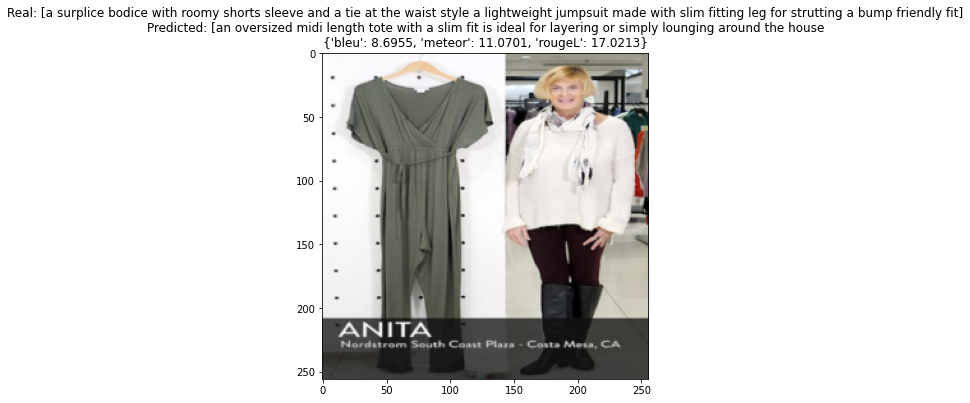

In [ ]:
# model.eval()
real, pred = test_on_data_sample(np.random.choice(range(0, len(data_val))))